# Part 0: The Fraud Detection Challenge at Scale

**Goal**: Understand the problem space and establish evaluation methodology before implementing solutions.

**What we'll cover**:
1. Why fraud detection is challenging
2. Why LLMs are promising (but expensive)
3. Our synthetic dataset and fraud patterns
4. Evaluation metrics we'll track
5. Success criteria for our approaches

In [1]:
# Setup
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from data.synthetic_generator import FraudDataGenerator
from src.metrics.tracker import MetricsTracker, AccuracyMetrics

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. The Fraud Detection Challenge

### Traditional Challenges

Fraud detection in e-commerce faces several challenges:

1. **High False Positive Rates**: Traditional rule-based systems flag 10-20% of legitimate transactions
   - Results in customer friction and lost revenue
   - Humans must review thousands of flagged transactions

2. **Evolving Fraud Patterns**: Fraudsters adapt quickly
   - Rule-based systems become outdated
   - Static ML models need frequent retraining

3. **Extreme Class Imbalance**: Fraud is rare (0.1-2% of transactions)
   - Makes ML training difficult
   - Easy to build 99% accurate model that catches 0% of fraud

4. **Explainability Requirements**: Must explain why transactions are flagged
   - Regulatory compliance (FCRA, GDPR)
   - Customer service needs clear reasons

### Why LLMs Are Promising

Large Language Models offer several advantages:

✅ **Semantic Understanding**: Can understand complex, nuanced patterns in transaction sequences

✅ **Few-Shot Learning**: Adapt to new fraud types with minimal examples

✅ **Natural Explanations**: Generate human-readable reasoning for decisions

✅ **Context Integration**: Combine transaction data with user history, location, timing

### The LLM Challenge: Cost & Scale

❌ **Context Window Limits**: GPT-4 can't analyze 1000+ transactions in one call

❌ **Token Costs**: At $2.50/1M input tokens, analyzing 1000 transactions costs $0.05-0.15

❌ **Latency**: Multi-second inference times don't work for real-time fraud prevention

❌ **Hallucination Risk**: LLMs may invent numbers or patterns that don't exist

## 2. Our Research Question

**"Can we reduce LLM fraud detection costs by 70%+ while maintaining 95%+ accuracy?"**

We'll test three approaches:
1. **Naive**: Send all transactions to GPT-4 (baseline)
2. **RAG**: Use semantic search to retrieve relevant patterns
3. **RLM**: Generate code to filter programmatically, then analyze with LLM

**Hypothesis**: RLM will achieve 70-90% cost reduction by:
- Using code for statistical filtering (cheap, fast)
- Using LLMs only for semantic reasoning (expensive, but on filtered data)

## 3. Load and Explore Our Dataset

In [2]:
# Load the generated dataset
df = pd.read_csv('../data/sample_transactions.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Dataset Shape: (10000, 37)

Columns: ['user_id', 'amount', 'timestamp', 'location', 'device', 'category', 'is_fraud', 'fraud_type', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'transaction_id']

First few rows:


,user_id,amount,timestamp,location,device,category,is_fraud,fraud_type,v1,v2,...,v20,v21,v22,v23,v24,v25,v26,v27,v28,transaction_id
0,U_0102,35.813717,1.735670e+09,Houston,mobile,pharmacy,False,NaN,0.368123,-0.908212,...,0.093575,-0.123309,0.827752,0.740429,1.321757,0.204492,-0.077210,-0.488382,0.473007,TXN_000000
1,U_0179,16.131759,1.735670e+09,LA,desktop,gas,False,NaN,-0.515486,-0.982363,...,-0.668445,0.078929,0.209819,-0.578160,0.507991,0.028438,0.082172,0.043050,0.122080,TXN_000001
2,U_0092,66.167934,1.735670e+09,Philadelphia,mobile,grocery,False,NaN,0.303673,0.225038,...,1.855268,0.855238,0.201152,-0.080267,-0.681542,0.152736,-1.109672,-0.542595,1.887043,TXN_000002
3,U_0014,63.305072,1.735670e+09,Houston,mobile,grocery,False,NaN,0.257609,0.073430,...,0.686912,-0.217455,0.226390,0.588099,0.173455,-0.220197,-0.148089,0.239797,0.143628,TXN_000003
4,U_0106,13.323819,1.735670e+09,Houston,desktop,restaurant,False,NaN,0.070056,0.187007,...,-0.503143,1.090798,-0.035884,0.482922,-0.253698,0.180786,-0.502724,0.296468,2.088749,TXN_000004


In [3]:
# Basic statistics
print("=== DATASET STATISTICS ===")
print(f"\nTotal Transactions: {len(df):,}")
print(f"Fraudulent: {df['is_fraud'].sum():,} ({df['is_fraud'].sum()/len(df)*100:.2f}%)")
print(f"Legitimate: {(~df['is_fraud']).sum():,} ({(~df['is_fraud']).sum()/len(df)*100:.2f}%)")
print(f"\nUnique Users: {df['user_id'].nunique():,}")
print(f"Transaction Amount Range: ${df['amount'].min():.2f} - ${df['amount'].max():.2f}")
print(f"Mean Transaction Amount: ${df['amount'].mean():.2f}")

=== DATASET STATISTICS ===

Total Transactions: 10,000
Fraudulent: 200 (2.00%)
Legitimate: 9,800 (98.00%)

Unique Users: 240
Transaction Amount Range: $4.17 - $500.00
Mean Transaction Amount: $46.51


## 4. Fraud Pattern Analysis

Our dataset includes 4 distinct fraud patterns:

In [4]:
# Load fraud pattern definitions
with open('../data/fraud_patterns.json', 'r') as f:
    fraud_patterns = json.load(f)

print("=== FRAUD PATTERN DEFINITIONS ===\n")
for pattern_name, pattern_info in fraud_patterns.items():
    print(f"{pattern_info['name']}:")
    print(f"  Description: {pattern_info['description']}")
    print(f"  Indicators: {pattern_info['indicators']}")
    print()

=== FRAUD PATTERN DEFINITIONS ===

Velocity Attack:
  Description: Multiple transactions in rapid succession from same user
  Indicators: {'time_window': '< 5 minutes', 'transaction_count': '> 8 transactions', 'typical_behavior': 'Normal users: 1-2 transactions per hour'}

Amount Anomaly:
  Description: Transaction amount significantly higher than normal
  Indicators: {'statistical_threshold': '> 3 standard deviations from mean', 'example': 'User average: $50, transaction: $5,000', 'context': 'No prior large purchases in history'}

Geographic Outlier:
  Description: Transactions from impossible locations
  Indicators: {'pattern': 'Location velocity > physically possible', 'example': 'NYC purchase, then Tokyo 2 hours later', 'physical_limit': 'Speed of air travel'}

Account Takeover:
  Description: Sudden behavioral pattern shift indicating compromised account
  Indicators: {'device_change': 'Different device than usual', 'category_shift': 'Unusual purchase categories', 'amount_change':

Fraud Type Distribution:
fraud_type
geographic          50
account_takeover    50
amount_anomaly      50
velocity            50
Name: count, dtype: int64


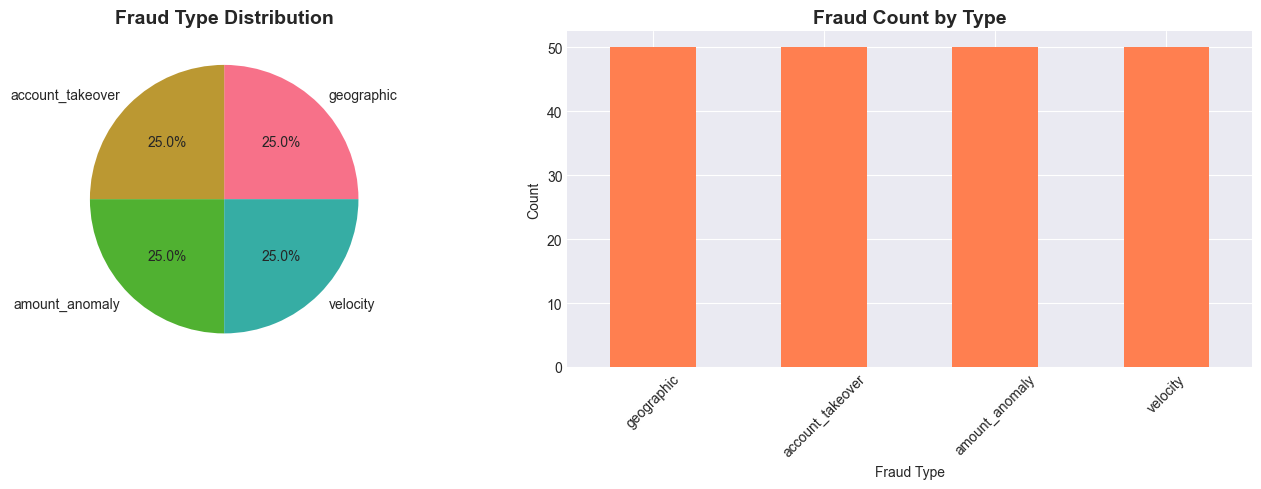

In [5]:
# Fraud type distribution
fraud_df = df[df['is_fraud'] == True]
fraud_type_counts = fraud_df['fraud_type'].value_counts()

print("Fraud Type Distribution:")
print(fraud_type_counts)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
axes[0].pie(fraud_type_counts.values, labels=fraud_type_counts.index, autopct='%1.1f%%')
axes[0].set_title('Fraud Type Distribution', fontsize=14, fontweight='bold')

# Bar chart
fraud_type_counts.plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Fraud Count by Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Fraud Type')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/visualizations/fraud_type_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Transaction Amount Analysis

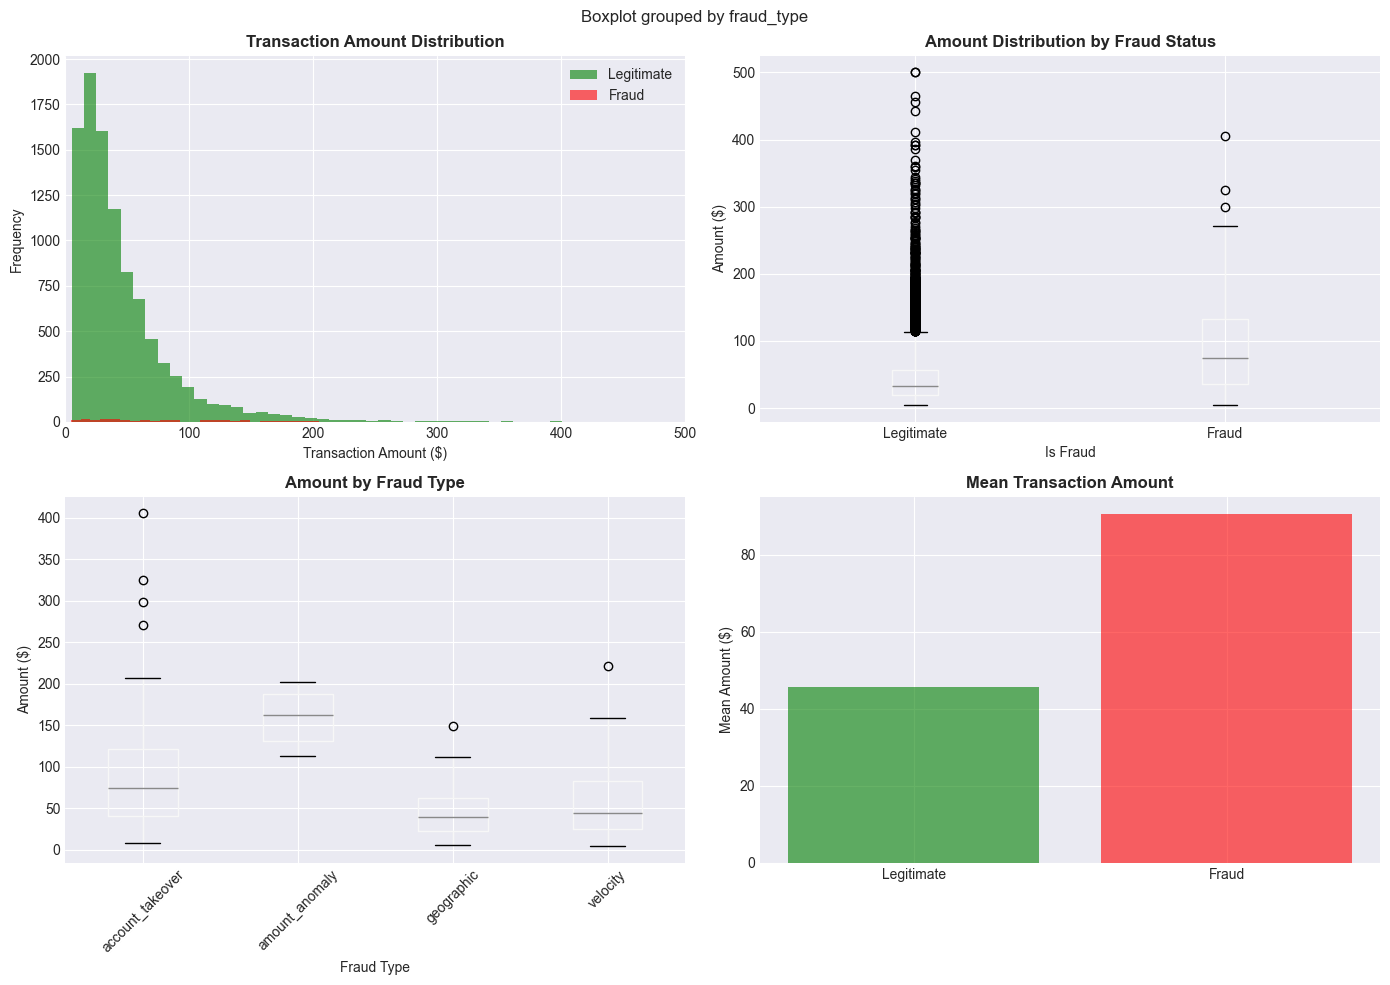


=== AMOUNT STATISTICS ===
Legitimate Mean: $45.61
Fraud Mean: $90.56
Ratio: 1.99x


In [6]:
# Amount distribution by fraud status
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution comparison
axes[0, 0].hist(df[df['is_fraud'] == False]['amount'], bins=50, alpha=0.6, label='Legitimate', color='green')
axes[0, 0].hist(df[df['is_fraud'] == True]['amount'], bins=50, alpha=0.6, label='Fraud', color='red')
axes[0, 0].set_xlabel('Transaction Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Transaction Amount Distribution', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 500)

# Box plot comparison
df.boxplot(column='amount', by='is_fraud', ax=axes[0, 1])
axes[0, 1].set_title('Amount Distribution by Fraud Status', fontweight='bold')
axes[0, 1].set_xlabel('Is Fraud')
axes[0, 1].set_ylabel('Amount ($)')
plt.sca(axes[0, 1])
plt.xticks([1, 2], ['Legitimate', 'Fraud'])

# Amount by fraud type
fraud_df.boxplot(column='amount', by='fraud_type', ax=axes[1, 0])
axes[1, 0].set_title('Amount by Fraud Type', fontweight='bold')
axes[1, 0].set_xlabel('Fraud Type')
axes[1, 0].set_ylabel('Amount ($)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Statistical comparison
stats_data = [
    df[df['is_fraud'] == False]['amount'].mean(),
    df[df['is_fraud'] == True]['amount'].mean()
]
axes[1, 1].bar(['Legitimate', 'Fraud'], stats_data, color=['green', 'red'], alpha=0.6)
axes[1, 1].set_title('Mean Transaction Amount', fontweight='bold')
axes[1, 1].set_ylabel('Mean Amount ($)')

plt.tight_layout()
plt.savefig('../results/visualizations/amount_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== AMOUNT STATISTICS ===")
print(f"Legitimate Mean: ${df[df['is_fraud'] == False]['amount'].mean():.2f}")
print(f"Fraud Mean: ${df[df['is_fraud'] == True]['amount'].mean():.2f}")
print(f"Ratio: {df[df['is_fraud'] == True]['amount'].mean() / df[df['is_fraud'] == False]['amount'].mean():.2f}x")

## 6. Temporal Patterns

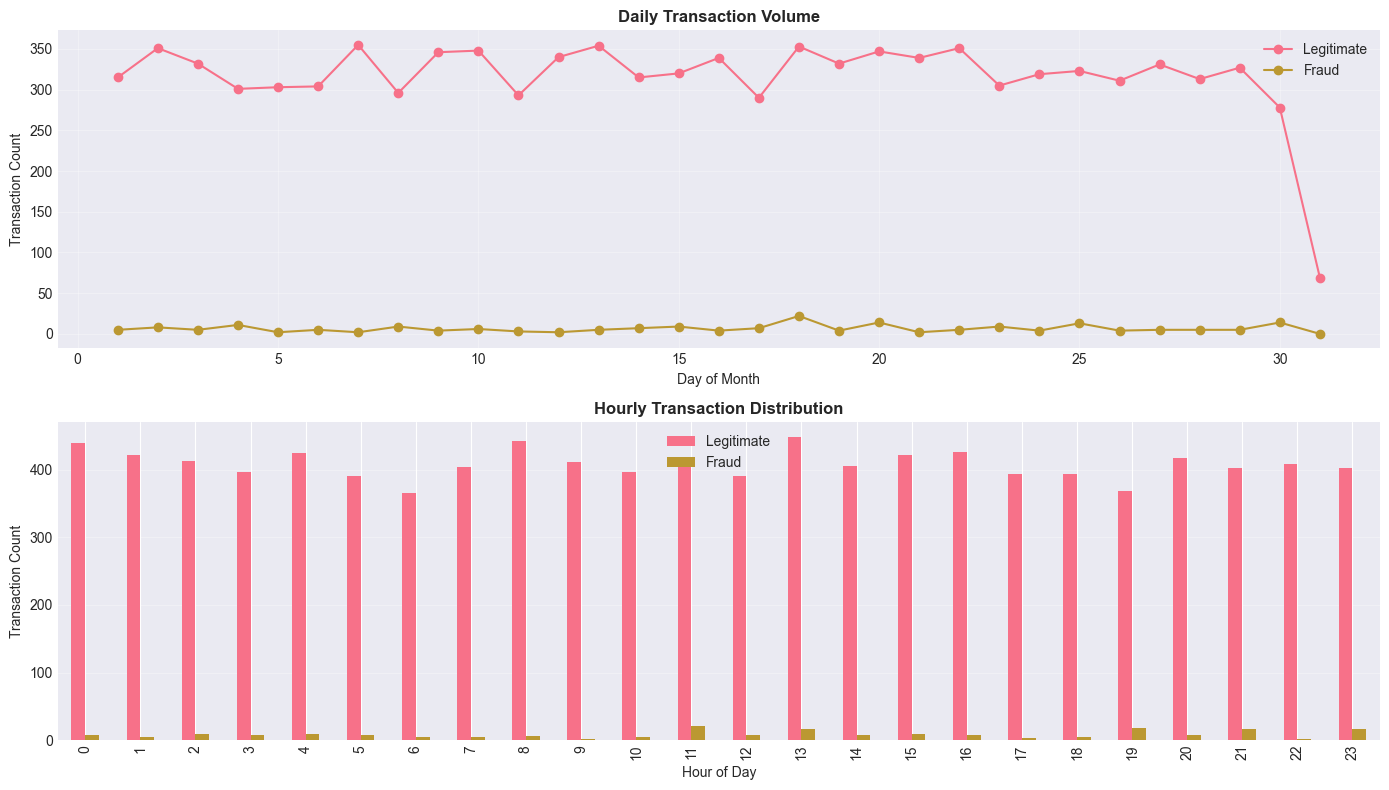

In [7]:
# Convert timestamp to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day

# Transactions over time
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Daily transaction count
daily_counts = df.groupby(['day', 'is_fraud']).size().unstack(fill_value=0)
daily_counts.plot(ax=axes[0], marker='o')
axes[0].set_title('Daily Transaction Volume', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Day of Month')
axes[0].set_ylabel('Transaction Count')
axes[0].legend(['Legitimate', 'Fraud'])
axes[0].grid(True, alpha=0.3)

# Hourly distribution
hourly_counts = df.groupby(['hour', 'is_fraud']).size().unstack(fill_value=0)
hourly_counts.plot(ax=axes[1], kind='bar')
axes[1].set_title('Hourly Transaction Distribution', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Transaction Count')
axes[1].legend(['Legitimate', 'Fraud'])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/visualizations/temporal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Feature Analysis (PCA Components)

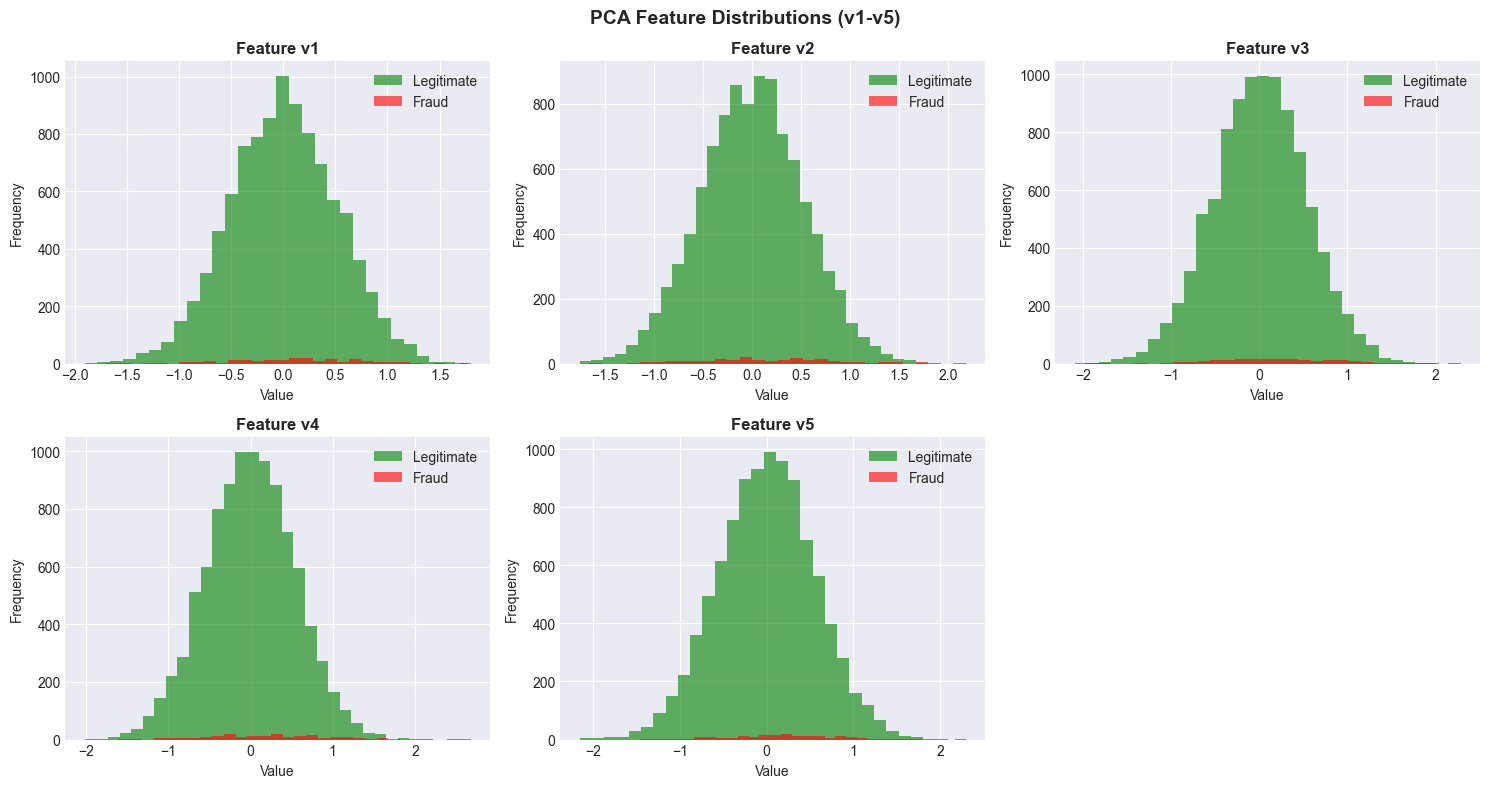

In [8]:
# Analyze first few PCA features
feature_cols = [f'v{i}' for i in range(1, 6)]  # First 5 features

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, feature in enumerate(feature_cols):
    axes[idx].hist(df[df['is_fraud'] == False][feature], bins=30, alpha=0.6, label='Legitimate', color='green')
    axes[idx].hist(df[df['is_fraud'] == True][feature], bins=30, alpha=0.6, label='Fraud', color='red')
    axes[idx].set_title(f'Feature {feature}', fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

# Hide last subplot
axes[-1].axis('off')

plt.suptitle('PCA Feature Distributions (v1-v5)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/visualizations/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Class Imbalance Visualization

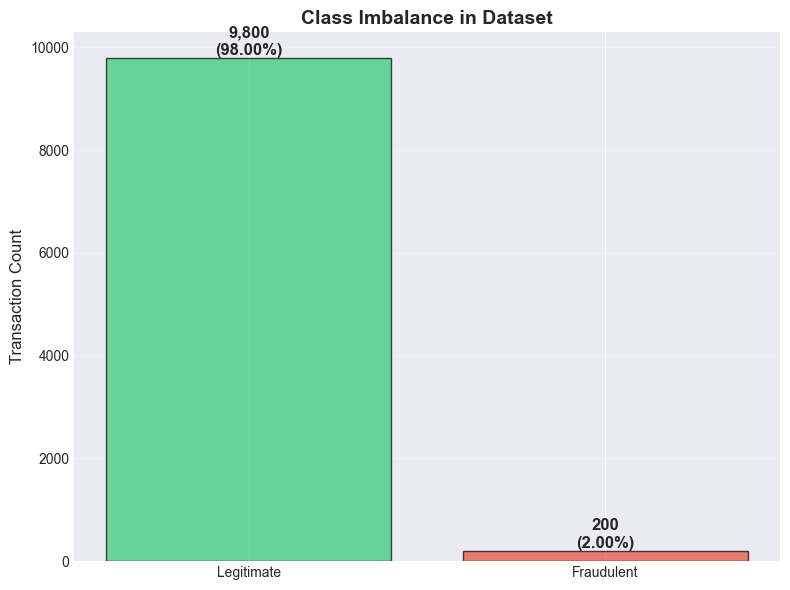


=== CLASS IMBALANCE ===
Imbalance Ratio: 1:49
This means for every 1 fraudulent transaction, there are 49 legitimate ones.


In [9]:
# Visualize class imbalance
fig, ax = plt.subplots(figsize=(8, 6))

class_counts = df['is_fraud'].value_counts()
colors = ['#2ecc71', '#e74c3c']
bars = ax.bar(['Legitimate', 'Fraudulent'], class_counts.values, color=colors, alpha=0.7, edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(df)*100:.2f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Transaction Count', fontsize=12)
ax.set_title('Class Imbalance in Dataset', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/visualizations/class_imbalance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== CLASS IMBALANCE ===" )
print(f"Imbalance Ratio: 1:{int((~df['is_fraud']).sum() / df['is_fraud'].sum())}")
print(f"This means for every 1 fraudulent transaction, there are {int((~df['is_fraud']).sum() / df['is_fraud'].sum())} legitimate ones.")

## 9. Define Evaluation Metrics

For fraud detection with class imbalance, we'll track multiple metrics:

In [10]:
# Initialize metrics tracker
tracker = MetricsTracker()

# Define what we'll track
metrics_definition = {
    'Accuracy Metrics': {
        'Precision': 'TP / (TP + FP) - Of predicted frauds, how many are actually fraud?',
        'Recall': 'TP / (TP + FN) - Of actual frauds, how many did we catch?',
        'F1 Score': '2 * (Precision * Recall) / (Precision + Recall) - Harmonic mean',
        'Accuracy': '(TP + TN) / Total - Overall correctness (misleading with imbalance!)'
    },
    'Cost Metrics': {
        'Total Tokens': 'Prompt + completion tokens',
        'Prompt Tokens': 'Input tokens (our context)',
        'Completion Tokens': 'Output tokens (LLM response)',
        'Cost (USD)': 'Based on GPT-4o pricing: $2.50/1M input, $10/1M output'
    },
    'Performance Metrics': {
        'Latency (ms)': 'Time from request to response',
        'Throughput': 'Transactions processed per second',
        'P50, P95, P99': 'Latency percentiles for production SLAs'
    },
    'Scalability Metrics': {
        'Max Batch Size': 'Maximum transactions in single request',
        'Context Utilization': 'Percentage of context window used',
        'Failure Rate': 'Percentage of requests that fail'
    }
}

print("=== EVALUATION METRICS FRAMEWORK ===\n")
for category, metrics in metrics_definition.items():
    print(f"{category}:")
    for metric, description in metrics.items():
        print(f"  • {metric}: {description}")
    print()

=== EVALUATION METRICS FRAMEWORK ===

Accuracy Metrics:
  • Precision: TP / (TP + FP) - Of predicted frauds, how many are actually fraud?
  • Recall: TP / (TP + FN) - Of actual frauds, how many did we catch?
  • F1 Score: 2 * (Precision * Recall) / (Precision + Recall) - Harmonic mean
  • Accuracy: (TP + TN) / Total - Overall correctness (misleading with imbalance!)

Cost Metrics:
  • Total Tokens: Prompt + completion tokens
  • Prompt Tokens: Input tokens (our context)
  • Completion Tokens: Output tokens (LLM response)
  • Cost (USD): Based on GPT-4o pricing: $2.50/1M input, $10/1M output

Performance Metrics:
  • Latency (ms): Time from request to response
  • Throughput: Transactions processed per second
  • P50, P95, P99: Latency percentiles for production SLAs

Scalability Metrics:
  • Max Batch Size: Maximum transactions in single request
  • Context Utilization: Percentage of context window used
  • Failure Rate: Percentage of requests that fail



## 10. Success Criteria

An approach is successful if it meets these criteria:

In [11]:
success_criteria = {
    'Accuracy': {
        'F1 Score': '>= 0.93',
        'Precision': '>= 0.90',
        'Recall': '>= 0.90',
        'Rationale': 'Industry baseline for fraud detection systems'
    },
    'Cost': {
        'Per Analysis': '< $0.05',
        'Annual (10K/day)': '< $180,000',
        'Rationale': 'Production budget constraints'
    },
    'Performance': {
        'Latency P95': '< 10 seconds',
        'Rationale': 'Acceptable for batch fraud screening'
    },
    'Scalability': {
        'Min Batch Size': '>= 500 transactions',
        'Rationale': 'Analyze user full 30-day history'
    },
    'Explainability': {
        'Citations': 'Required',
        'Reasoning': 'Natural language',
        'Rationale': 'Regulatory compliance and customer service'
    }
}

print("=== SUCCESS CRITERIA ===\n")
for category, criteria in success_criteria.items():
    print(f"{category}:")
    for key, value in criteria.items():
        if key != 'Rationale':
            print(f"  {key}: {value}")
    if 'Rationale' in criteria:
        print(f"  → {criteria['Rationale']}")
    print()

=== SUCCESS CRITERIA ===

Accuracy:
  F1 Score: >= 0.93
  Precision: >= 0.90
  Recall: >= 0.90
  → Industry baseline for fraud detection systems

Cost:
  Per Analysis: < $0.05
  Annual (10K/day): < $180,000
  → Production budget constraints

Performance:
  Latency P95: < 10 seconds
  → Acceptable for batch fraud screening

Scalability:
  Min Batch Size: >= 500 transactions
  → Analyze user full 30-day history

Explainability:
  Citations: Required
  Reasoning: Natural language
  → Regulatory compliance and customer service



## 11. The Central Question

**Can we achieve 70%+ cost reduction while maintaining 95%+ F1 score?**

### Current Industry Baselines

Based on our research:
- **Naive LLM**: High accuracy but expensive (~$299K/year at scale)
- **RAG**: Better efficiency but still context-limited (~$208K/year)
- **Traditional ML**: Cheap but requires constant retraining, lacks explainability

### Our Hypothesis: RLM Will Win

**Why RLM should work**:
1. **Statistical Filtering = Code**: Mean, std dev, outliers → Python (fast, cheap)
2. **Semantic Reasoning = LLM**: "Why is this suspicious?" → GPT-4 (expensive, but only on filtered subset)
3. **Separation of Concerns**: Right tool for the right job

**Expected Results**:
- Cost: ~$17K/year (94% reduction vs naive)
- Accuracy: F1 >= 0.95 (maintained or improved)
- Scalability: 10,000+ transactions per request
- Explainability: Grounded citations to actual data

## 12. Summary Statistics for Reference

In [12]:
# Create comprehensive summary
summary = {
    'dataset': {
        'total_transactions': len(df),
        'fraudulent': int(df['is_fraud'].sum()),
        'legitimate': int((~df['is_fraud']).sum()),
        'fraud_rate': float(df['is_fraud'].sum() / len(df)),
        'unique_users': int(df['user_id'].nunique()),
        'date_range_days': int((df['timestamp'].max() - df['timestamp'].min()) / 86400)
    },
    'fraud_patterns': {
        'velocity': int((df['fraud_type'] == 'velocity').sum()),
        'amount_anomaly': int((df['fraud_type'] == 'amount_anomaly').sum()),
        'geographic': int((df['fraud_type'] == 'geographic').sum()),
        'account_takeover': int((df['fraud_type'] == 'account_takeover').sum())
    },
    'amount_stats': {
        'legitimate_mean': float(df[df['is_fraud'] == False]['amount'].mean()),
        'fraud_mean': float(df[df['is_fraud'] == True]['amount'].mean()),
        'overall_mean': float(df['amount'].mean()),
        'overall_std': float(df['amount'].std())
    }
}

# Save summary
with open('../results/metrics/dataset_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("=== DATASET SUMMARY ===")
print(json.dumps(summary, indent=2))

=== DATASET SUMMARY ===
{
  "dataset": {
    "total_transactions": 10000,
    "fraudulent": 200,
    "legitimate": 9800,
    "fraud_rate": 0.02,
    "unique_users": 240,
    "date_range_days": 29
  },
  "fraud_patterns": {
    "velocity": 50,
    "amount_anomaly": 50,
    "geographic": 50,
    "account_takeover": 50
  },
  "amount_stats": {
    "legitimate_mean": 45.61333347047744,
    "fraud_mean": 90.56486852589538,
    "overall_mean": 46.5123641715858,
    "overall_std": 43.7993682839908
  }
}


## Conclusion: Phase 0

✅ **What we've established**:
1. Realistic fraud detection dataset (10,000 transactions, 2% fraud rate)
2. Four distinct fraud patterns (velocity, amount, geographic, account takeover)
3. Comprehensive evaluation framework (accuracy, cost, performance, scalability)
4. Clear success criteria (F1 >= 0.93, cost < $50K/year, explainable)

✅ **Key Insights**:
- Class imbalance (1:49 ratio) makes this challenging
- Fraud transactions have distinct statistical signatures
- Different fraud types require different detection strategies

✅ **Next Steps**:
- **Phase 1**: Implement Naive LLM approach (baseline)
- **Phase 2**: Implement RAG approach (semantic search)
- **Phase 3**: Implement RLM approach (our hypothesis)
- **Phase 4**: Comprehensive comparison with statistical analysis

---

**Continue to [Part 1: Naive Approach](01_naive_approach.ipynb)** →